In [1]:
import sys 
sys.path.append("..") 

import numpy as np
from braiding_model import BraidOperator, show_braid_words
from braiding_model import GeneratorBraid, obtain_model_braid, obtain_model_torus_knot
from braiding_model import sigma_z, sigma_x, sigma_y, sigma_0
from braiding_model import PerturbationModel
from braiding_model import UnknotGenerator

from machine_learning import Classifier, Cluster
from topology import topology_comparator, similarity_function
from functools import partial

import matplotlib.pyplot as plt

p1 = PerturbationModel()
p1.set_parameters(t1=0.1,t2=0.0)

p2 = PerturbationModel()
p2.set_parameters(t1=-0.1,t2=0.0)

p3 = PerturbationModel()
p3.set_parameters(t1=0.1,t2=0.1)

p4 = PerturbationModel()
p4.set_parameters(t1=0.0,t2=-0.1)

perturbations = [p1,p2,p3,p4]

np.seterr(all="ignore") # ignore some numerical errors

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# define unknot 

In [2]:
n_band = 4
generator = UnknotGenerator(n_band=n_band)
unknot_models = generator.generate()
print("The number of unknot models: ", len(unknot_models))
for model in unknot_models[:5]:
    show_braid_words(model.get_braid_words())

The number of unknot models:  12


$\sigma_1$ $\sigma_2$ $\sigma_3$ 

$\sigma_1$ $\sigma_3$ $\sigma_2$ 

$\sigma_2$ $\sigma_1$ $\sigma_3$ 

$\sigma_2$ $\sigma_3$ $\sigma_1$ 

$\sigma_3$ $\sigma_1$ $\sigma_2$ 

In [11]:
braid_operator_list = [BraidOperator(i) for i in range(1, n_band)] + [BraidOperator(i,True) for i in range(1, n_band)]
for op in braid_operator_list:
    show_braid_words([op])
    
generator = GeneratorBraid(n_band=n_band, braid_operator_list=braid_operator_list)
#models, braid_operator_list_gen = generator.get_all_combination_generate_sample(n_length=#)
models, braid_operator_list_gen = generator.get_random_generate_sample(n_sample=1000, n_max_operator=6)
#models, braid_operator_list_gen = generator.get_permutation_generate_sample(n_permutation=6)

print("The number of braids: ", len(braid_operator_list_gen))

$\sigma_1$ 

$\sigma_2$ 

$\sigma_3$ 

$\sigma^{-1}_1$ 

$\sigma^{-1}_2$ 

$\sigma^{-1}_3$ 

The number of braids:  1000


In [12]:
import multiprocessing

n_core = 64 # the numebr of cores used in computation
fast_mode = True
func = partial(similarity_function, perturbations=perturbations, fast_mode=fast_mode)
find_models_list = list()

def worker(X, X0):
    return func(X, X0)
    
n_unknot_models = len(unknot_models)
similarities = np.zeros((len(unknot_models), len(models)))
for i, unknot_model in enumerate(unknot_models):
#     for j, unknot_model in enumerate(unknot_models):
#         if func(model, unknot_model) > 0:
#             flag = True
#             break

    f = partial(worker, X0=unknot_model)           
    pool = multiprocessing.Pool(n_core)
    _similarities = pool.map(f, models)
    pool.close()
    pool.join()

    similarities[i] = _similarities
    
    if ((i+1)%int(n_unknot_models/10))==0:
        print(np.round((i+1)/n_unknot_models*100,1),'%...')
    
for i, model in enumerate(models):
    if np.any(similarities[:,i] > 0.5):
        find_models_list.append(model)
        show_braid_words(model.get_braid_words())

print("The number of unknot braids: ", len(find_models_list))

8.3 %...
16.7 %...
25.0 %...
33.3 %...
41.7 %...
50.0 %...
58.3 %...
66.7 %...
75.0 %...
83.3 %...
91.7 %...
100.0 %...


$\sigma^{-1}_2$ $\sigma^{-1}_1$ $\sigma^{-1}_3$ 

$\sigma_2$ $\sigma^{-1}_3$ $\sigma_3$ $\sigma_1$ $\sigma_3$ 

$\sigma^{-1}_1$ $\sigma^{-1}_3$ $\sigma^{-1}_2$ 

$\sigma^{-1}_3$ $\sigma^{-1}_1$ $\sigma^{-1}_2$ 

$\sigma_3$ $\sigma_2$ $\sigma_1$ $\sigma^{-1}_2$ $\sigma_2$ 

$\sigma_2$ $\sigma_1$ $\sigma_3$ $\sigma^{-1}_3$ $\sigma_3$ 

$\sigma^{-1}_2$ $\sigma^{-1}_1$ $\sigma^{-1}_2$ $\sigma^{-1}_3$ $\sigma_1$ 

$\sigma_2$ $\sigma^{-1}_1$ $\sigma_3$ $\sigma_1$ $\sigma_1$ 

$\sigma^{-1}_1$ $\sigma_2$ $\sigma^{-1}_2$ $\sigma^{-1}_3$ $\sigma^{-1}_2$ 

$\sigma^{-1}_1$ $\sigma^{-1}_3$ $\sigma^{-1}_2$ 

$\sigma_3$ $\sigma_2$ $\sigma_1$ 

$\sigma_2$ $\sigma_1$ $\sigma_3$ 

$\sigma^{-1}_3$ $\sigma^{-1}_2$ $\sigma^{-1}_1$ 

$\sigma^{-1}_2$ $\sigma^{-1}_3$ $\sigma^{-1}_1$ 

$\sigma_3$ $\sigma_1$ $\sigma_2$ 

$\sigma_1$ $\sigma_3$ $\sigma_2$ 

The number of unknot braids:  16


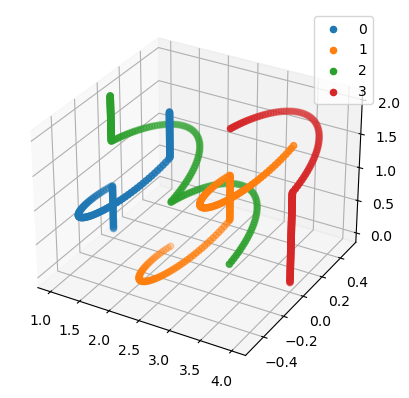

In [13]:
ks = np.linspace(0, 2 * np.pi, 200)

index = 0
Es = np.array([find_models_list[index].get_energies(k) for k in ks])
ax = plt.figure().add_subplot(projection='3d')
for index in range(n_band):
    x = np.real(Es[:, index])
    y = np.imag(Es[:, index])
    ax.scatter(x, y, ks/(np.pi), label='{0}'.format(index))
    ax.legend()

plt.show()

# save data

In [15]:
with open('./fig4/unknot.txt','w') as fileop: 
    for model in find_models_list:
        fileop.write(str([(op.get_n(), op.get_is_inverse()) for op in model.get_braid_words()])+'\n')

In [16]:
for i, model in enumerate(find_models_list):
    show_braid_words(model.get_braid_words())
    model.save_band('./fig4/case {i}.txt'.format(i=i))

$\sigma^{-1}_2$ $\sigma^{-1}_1$ $\sigma^{-1}_3$ 

$\sigma_2$ $\sigma^{-1}_3$ $\sigma_3$ $\sigma_1$ $\sigma_3$ 

$\sigma^{-1}_1$ $\sigma^{-1}_3$ $\sigma^{-1}_2$ 

$\sigma^{-1}_3$ $\sigma^{-1}_1$ $\sigma^{-1}_2$ 

$\sigma_3$ $\sigma_2$ $\sigma_1$ $\sigma^{-1}_2$ $\sigma_2$ 

$\sigma_2$ $\sigma_1$ $\sigma_3$ $\sigma^{-1}_3$ $\sigma_3$ 

$\sigma^{-1}_2$ $\sigma^{-1}_1$ $\sigma^{-1}_2$ $\sigma^{-1}_3$ $\sigma_1$ 

$\sigma_2$ $\sigma^{-1}_1$ $\sigma_3$ $\sigma_1$ $\sigma_1$ 

$\sigma^{-1}_1$ $\sigma_2$ $\sigma^{-1}_2$ $\sigma^{-1}_3$ $\sigma^{-1}_2$ 

$\sigma^{-1}_1$ $\sigma^{-1}_3$ $\sigma^{-1}_2$ 

$\sigma_3$ $\sigma_2$ $\sigma_1$ 

$\sigma_2$ $\sigma_1$ $\sigma_3$ 

$\sigma^{-1}_3$ $\sigma^{-1}_2$ $\sigma^{-1}_1$ 

$\sigma^{-1}_2$ $\sigma^{-1}_3$ $\sigma^{-1}_1$ 

$\sigma_3$ $\sigma_1$ $\sigma_2$ 

$\sigma_1$ $\sigma_3$ $\sigma_2$ 

In [19]:
unknot_models[0].save_band('./fig4/unknot_bands.txt')